# Yolov11, Faster-RNN, and SSD

In [1]:
import torch
import torchvision
from torchvision.io.image import decode_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import torchvision.transforms.functional as F
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights

from ultralytics import YOLO

import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = ("bus.jpg")


## Loading models

### Yolov11

In [3]:
yolov11 = YOLO("yolo11n.pt")


image 1/1 /home/kien/Desktop/projects/Amir_research/pretrain_models/bus.jpg: 640x480 4 persons, 1 bus, 96.0ms
Speed: 4.6ms preprocess, 96.0ms inference, 89.5ms postprocess per image at shape (1, 3, 640, 480)


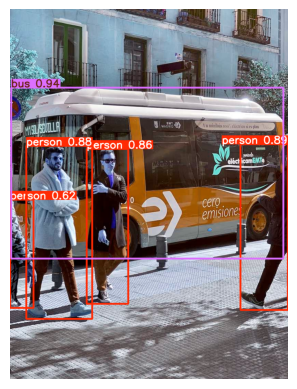

In [4]:
results = yolov11(img_path)
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()

### Faster-RNN

In [5]:
import torch

torch.cuda.empty_cache() 

In [ ]:
#Pytorch use uint8 format
img = decode_image(img_path)

# Initialize model with pretrained weights
faster_rnn_weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
faster_rnn_model = fasterrcnn_resnet50_fpn_v2(weights=faster_rnn_weights, box_score_thresh=0.9).to(device)

faster_rnn_model.eval()



In [ ]:
# Step 2: Initialize the inference transforms
preprocess = faster_rnn_weights.transforms()

batch = [preprocess(img).to(device)]

# Step 4: Use the model and visualize the prediction
prediction = faster_rnn_model(batch)[0]
prediction

{'boxes': tensor([[5.3435e+01, 4.0178e+02, 2.3557e+02, 9.0763e+02],
         [2.1098e+01, 2.2450e+02, 8.0221e+02, 7.5658e+02],
         [2.2024e+02, 4.0452e+02, 3.4794e+02, 8.6075e+02],
         [6.6802e+02, 3.9946e+02, 8.1000e+02, 8.8180e+02],
         [8.7596e-01, 5.4475e+02, 7.5111e+01, 8.7863e+02],
         [1.3686e+02, 4.7301e+02, 1.4915e+02, 5.0557e+02],
         [4.2635e+02, 1.5026e+02, 5.3286e+02, 1.9099e+02],
         [2.9285e+02, 5.7677e+02, 3.0953e+02, 6.4322e+02],
         [2.8729e+02, 4.7691e+02, 3.0082e+02, 5.2484e+02],
         [1.2095e+02, 6.9423e+02, 1.6983e+02, 8.2122e+02],
         [2.2389e+02, 5.9868e+02, 2.9156e+02, 7.0531e+02],
         [3.0337e+02, 5.6062e+02, 3.3730e+02, 7.0178e+02],
         [5.9202e+02, 3.9303e+02, 6.4084e+02, 4.5200e+02],
         [2.9007e+00, 6.8288e+02, 6.2682e+01, 7.5425e+02],
         [2.2345e+02, 6.6607e+02, 2.9085e+02, 7.0860e+02],
         [6.2402e+02, 3.9754e+02, 6.4070e+02, 4.4367e+02],
         [1.1197e+02, 1.8214e+02, 1.6221e+02, 2

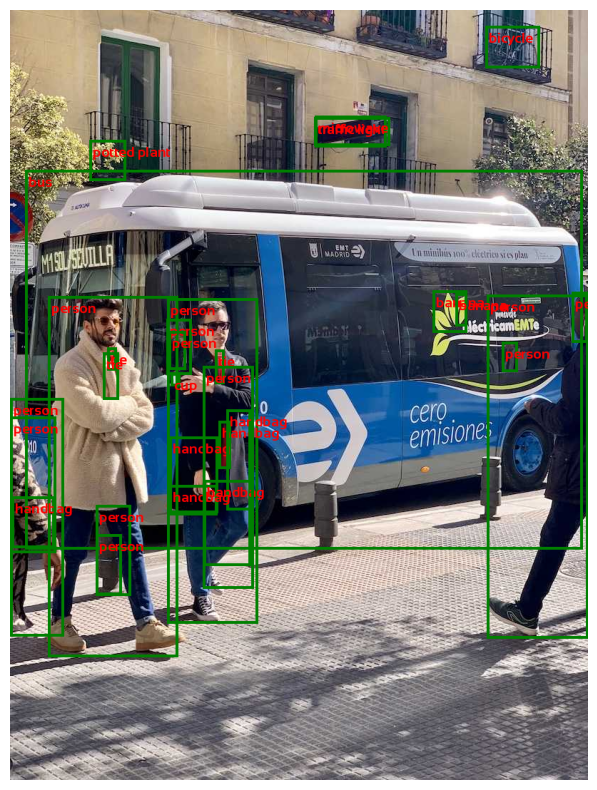

In [9]:
labels = [faster_rnn_weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="green",
                          label_colors="red",
                          width=4,
                          font="./../font/Sansation-Bold.ttf",
                          font_size=20)
box_np = box.movedim(0, -1)

plt.figure(figsize=(10,10))
plt.imshow(box_np)
plt.axis("off")
plt.show()

### SSD

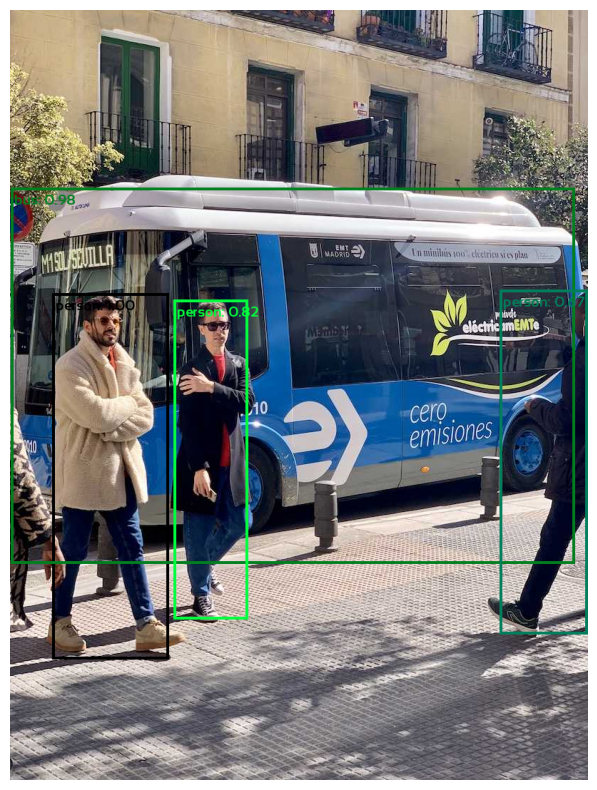

In [10]:
weights = SSD300_VGG16_Weights.COCO_V1
model = ssd300_vgg16(weights=weights, box_score_thresh=0.9).to(device)
categories = weights.meta["categories"]
preprocess = weights.transforms()  # expects a PIL Image

model.to(device)
model.eval()

input_tensor = preprocess(img).to(device)
outputs = model([input_tensor])
pred = outputs[0] 

# -------- Filter by confidence and map labels --------
conf_thresh = 0.5
keep = pred["scores"] >= conf_thresh

boxes  = pred["boxes"][keep]  
labels = pred["labels"][keep]
scores = pred["scores"][keep]

label_text = [f"{categories[i]}: {s:.2f}" for i, s in zip(labels.tolist(), scores.tolist())]

boxed = draw_bounding_boxes(input_tensor, 
                            boxes, 
                            labels=label_text, 
                            width=4,
                            font="./../font/Sansation-Bold.ttf",
                            font_size=20)
output = boxed.movedim(0, -1)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.axis("off")
plt.show()